## 🧩 Part 1 — What Are Embeddings? (Lecture 3.1)

**Goal:** Visualize how similar texts get similar embeddings and understand vector-based similarity.

### Step 1: Install Dependencies

In [1]:
!pip install openai faiss-cpu numpy pandas matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Step 2: Import Libraries and Configure OpenRouter API

**Important:** Get your free API key from [https://openrouter.ai/keys](https://openrouter.ai/keys)

In [ ]:
import numpy as np
import pandas as pd
import faiss
import matplotlib.pyplot as plt
from openai import OpenAI
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get API key from environment variable
api_key = os.getenv("OPENROUTER_API_KEY")

if not api_key:
    raise ValueError("OPENROUTER_API_KEY not found! Please set it in your .env file")

# Configure OpenRouter API (OpenAI-compatible)
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=api_key
)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


### Step 3: Define Helper Functions

Create utility functions for embedding generation and similarity calculation.

In [3]:
def get_embedding(text, engine="openai/text-embedding-3-small"):
    """
    Generate embeddings using OpenRouter API
    """
    text = text.replace("\n", " ")
    response = client.embeddings.create(
        input=[text],
        model=engine
    )
    return response.data[0].embedding

def cosine_similarity(vec1, vec2):
    """
    Calculate cosine similarity between two vectors
    Returns a value between -1 and 1 (1 = identical, 0 = orthogonal, -1 = opposite)
    """
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

print("✅ Helper functions defined!")

✅ Helper functions defined!


### Step 4: Create a Sample Dataset

In [4]:
sentences = [
    "The cat sat on the mat.",
    "A dog is barking loudly.",
    "Cats love to sleep on mats.",
    "Artificial Intelligence can transform industries.",
    "Machine learning models use data to make predictions."
]

print("Sample sentences:")
for i, s in enumerate(sentences):
    print(f"{i}: {s}")

Sample sentences:
0: The cat sat on the mat.
1: A dog is barking loudly.
2: Cats love to sleep on mats.
3: Artificial Intelligence can transform industries.
4: Machine learning models use data to make predictions.


### Step 5: Generate Embeddings

In [6]:
embeddings = [get_embedding(s, engine="openai/text-embedding-3-small") for s in sentences]
embeddings = np.array(embeddings)

print(f"✅ Generated embeddings with shape: {embeddings.shape}")
print(embeddings)

✅ Generated embeddings with shape: (5, 1536)
[[-0.02443521 -0.03736144  0.00102628 ...  0.0043403  -0.02995757
  -0.00308953]
 [ 0.02911487  0.02371938  0.03330674 ... -0.00347853  0.00428267
   0.00020914]
 [ 0.00293817 -0.00686978  0.0269011  ...  0.01312543 -0.03980978
   0.0014307 ]
 [-0.02005318 -0.01258855  0.00145712 ... -0.01070202 -0.00946179
   0.0378006 ]
 [ 0.00921843  0.00982276  0.03102862 ... -0.01507841 -0.03340629
   0.0085299 ]]


### Step 6: Compare Semantic Similarity

**✅ Expected Output:** Higher similarity between sentence 0 and 2 (both about cats), lower between 0 and 4.

In [7]:
sim = cosine_similarity(embeddings[0], embeddings[2])
diff = cosine_similarity(embeddings[0], embeddings[4])

print(f"Similarity (Cat-Mat pair): {sim:.3f}")
print(f"Similarity (Cat vs Machine Learning): {diff:.3f}")
print("\n✅ This visually demonstrates how embeddings capture meaning, not just words.")

Similarity (Cat-Mat pair): 0.652
Similarity (Cat vs Machine Learning): 0.101

✅ This visually demonstrates how embeddings capture meaning, not just words.


---

## 🧠 Part 2 — Introduction to Vector Databases (Lecture 3.2)

**Goal:** Understand how FAISS stores and indexes embeddings for efficient retrieval.

### Step 1: Initialize FAISS Index

In [10]:
dimension = len(embeddings[0])
index = faiss.IndexFlatL2(dimension)
index.add(np.array(embeddings).astype('float32'))

print(f"Total vectors in index: {index.ntotal}")


Total vectors in index: 5


### Step 2: Test a Query

**✅ Expected Output:** It should retrieve cat-related sentences. This shows semantic retrieval instead of keyword matching.

In [15]:
query = "A sleepy kitten lying on a rug."
# query="what is the use of embeddings in machine learning"
query_vec = get_embedding(query, engine="openai/text-embedding-3-small")
D, I = index.search(np.array([query_vec]).astype('float32'), k=2)

print(f"Query: '{query}'\n")
for rank, idx in enumerate(I[0]):
    print(f"Result {rank+1}: {sentences[idx]} (Distance: {D[0][rank]:.3f})")

Query: 'A sleepy kitten lying on a rug.'

Result 1: Cats love to sleep on mats. (Distance: 0.992)
Result 2: The cat sat on the mat. (Distance: 1.050)


---

## ⚙️ Part 3 — Building and Querying Vector Stores (Lecture 3.3)

**Goal:** Build a reusable function that stores, indexes, and queries any text dataset.

### Step 1: Build a Reusable Pipeline

In [16]:
class SimpleVectorStore:
    def __init__(self, engine="openai/text-embedding-3-small"):
        self.engine = engine
        self.texts = []
        self.embeddings = []
        self.index = None
 
    def add_texts(self, texts):
        self.texts.extend(texts)
        new_embeddings = [get_embedding(t, engine=self.engine) for t in texts]
        self.embeddings.extend(new_embeddings)
        dim = len(new_embeddings[0])
        self.index = faiss.IndexFlatL2(dim)
        self.index.add(np.array(self.embeddings).astype("float32"))
 
    def query(self, text, top_k=2):
        q_emb = get_embedding(text, engine=self.engine)
        D, I = self.index.search(np.array([q_emb]).astype("float32"), top_k)
        return [(self.texts[i], D[0][rank]) for rank, i in enumerate(I[0])]

print("✅ SimpleVectorStore class defined!")

✅ SimpleVectorStore class defined!


### Step 2: Test the Store

**✅ Expected Output:** You'll get the top 2 most relevant sentences — both about cats or mats.

In [17]:
store = SimpleVectorStore()
store.add_texts(sentences)
results = store.query("Tell me something about cats.", top_k=2)

print("Query Results:")
for r in results:
    print(f"Retrieved: {r[0]} | Distance: {r[1]:.3f}")

Query Results:
Retrieved: Cats love to sleep on mats. | Distance: 1.012
Retrieved: The cat sat on the mat. | Distance: 1.187


---

## 💡 Bonus Challenge

### Visualize Embeddings Using PCA

Show clusters of related meanings in 2D space.

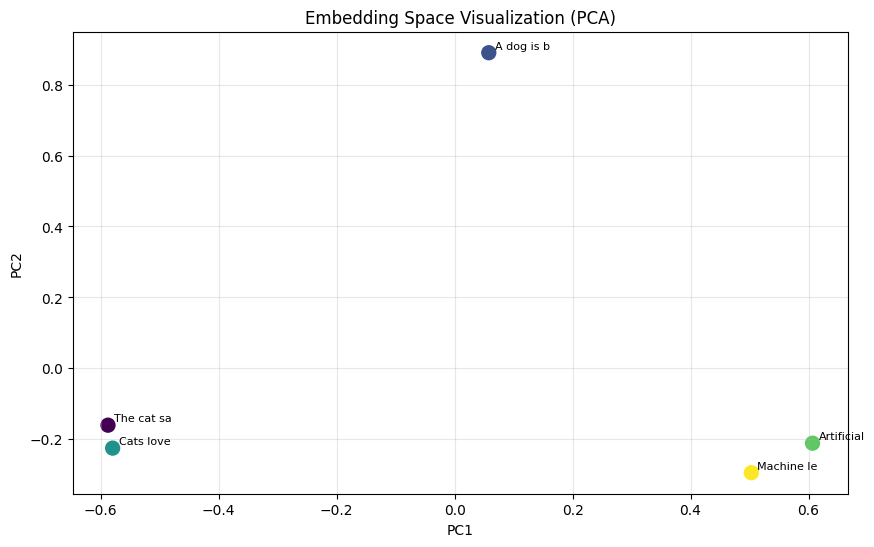

💡 Try replacing FAISS with Chroma or Pinecone to connect theory with enterprise tools!


In [18]:
from sklearn.decomposition import PCA

reduced = PCA(n_components=2).fit_transform(embeddings)
plt.figure(figsize=(10, 6))
plt.scatter(reduced[:,0], reduced[:,1], s=100, c=range(len(sentences)), cmap='viridis')

for i, s in enumerate(sentences):
    plt.text(reduced[i,0]+0.01, reduced[i,1]+0.01, s[:10], fontsize=8)

plt.title('Embedding Space Visualization (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, alpha=0.3)
plt.show()

print("💡 Try replacing FAISS with Chroma or Pinecone to connect theory with enterprise tools!")

---

## 📘 Deliverables

Jupyter/Colab notebook with:

1. ✅ Embedding similarity test results
2. ✅ Retrieval outputs
3. ✅ Optional visualization screenshot

---

## 🧭 Summary

By completing this lab, learners will:

- ✅ Understand how embeddings capture semantic meaning
- ✅ Learn to store and query text vectors using FAISS
- ✅ Build a simple vector store class ready for integration in a full RAG pipeline

### Using OpenRouter API (Free Tier)

This lab uses **OpenRouter** which provides:
- Free access to various models (with rate limits)
- OpenAI-compatible API
- No credit card required for basic usage

**Get your free API key**: [https://openrouter.ai/keys](https://openrouter.ai/keys)

---

## 🎉 Congratulations!

You've successfully completed the Embeddings and Vector Databases lab! 🚀